In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from tensorflow.keras import models, layers, Input
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor

In [ ]:
df = pd.read_csv("datasets/california_housing.csv")

In [3]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [4]:
print("Before: ", df.shape)

z = zscore(df)
df = df[(np.abs(z) <= 3).all(axis=1)]

print("After: ", df.shape)

Before:  (20640, 9)
After:  (19794, 9)


In [5]:
x_train, x_test, y_train, y_test = train_test_split(
    df.drop(columns=["target"]),
    df["target"],
    test_size=0.2,
    train_size=0.8,
    random_state=42
)

In [6]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [7]:
def create_model(hidden_layers=[64,32], optimizer="adam", callbacks=None):
    model = models.Sequential()
    model.add(layers.Input(shape=(x_train.shape[1],)))
    for units in hidden_layers:
        model.add(layers.Dense(units, activation="relu"))
    model.add(layers.Dense(1))
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model

early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

model = KerasRegressor(
    model=create_model,
    verbose=0,
    model__callbacks=[early_stop]
)

param_dist = {
    "model__hidden_layers": [[64,32], [128,64], [128,64,32]],
    "model__optimizer": ["adam", "rmsprop"],
    "batch_size": [16, 32],
    "epochs": [50]
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=5,
    cv=2,
    scoring="neg_mean_absolute_error",
    n_jobs=1,
    random_state=42
)

random_search_result = random_search.fit(x_train, y_train)

print(f"Best MAE: {-random_search_result.best_score_} using {random_search_result.best_params_}")

Best MAE: 0.36203496843074545 using {'model__optimizer': 'rmsprop', 'model__hidden_layers': [128, 64, 32], 'epochs': 50, 'batch_size': 16}


In [8]:
model = models.Sequential(
    [
        Input(shape=(x_train.shape[1],)),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1)
    ]
)

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_38 (Dense)                │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,521 (45.00 KB)

 Trainable params: 11,521 (45.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mse"])

In [10]:
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
history = model.fit(
    x_train, 
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    callbacks=[es]
)

Epoch 1/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4486 - mse: 0.4486 - val_loss: 0.3713 - val_mse: 0.3713
Epoch 2/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3440 - mse: 0.3440 - val_loss: 0.3449 - val_mse: 0.3449
Epoch 3/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3238 - mse: 0.3238 - val_loss: 0.3315 - val_mse: 0.3315
Epoch 4/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3094 - mse: 0.3094 - val_loss: 0.3218 - val_mse: 0.3218
Epoch 5/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2973 - mse: 0.2973 - val_loss: 0.3238 - val_mse: 0.3238
Epoch 6/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2931 - mse: 0.2931 - val_loss: 0.3148 - val_mse: 0.3148
Epoch 7/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2859 - mse: 0.2859 - val_loss: 0.3528 - val_mse: 0.3528
Epoch 8/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2798 - mse: 0.2798 - val_loss: 0.3053 - val_mse: 0.3053
Epoch 9/50
792/792 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - lo

In [11]:
y_pred = model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

r2 = r2_score(y_test, y_pred)
print("R² Score:", r2)

124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
MAE: 0.3648347923420932
R² Score: 0.7619883999646696


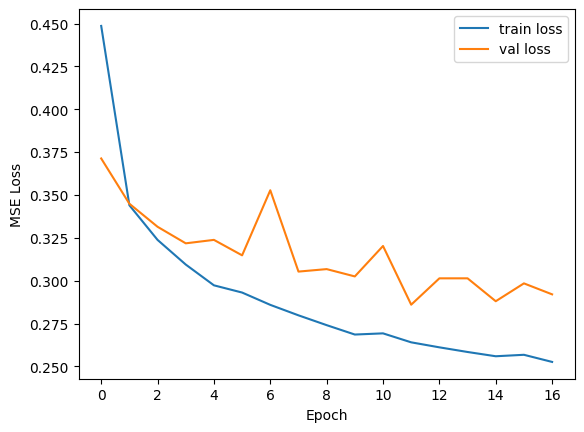

In [12]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()